# Notebook 07 — Final Model Analysis & Explainability

## Step 1 — Imports, paths, and global config

In [64]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch

from sklearn import metrics

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"
LABEL_COL = "Label_6h"


def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_LABELING = REPORTS_ROOT / "results" / "02_labeling_eda"
RESULTS_BASELINES = REPORTS_ROOT / "results" / "03_feature_engineering_baselines"
RESULTS_BOOSTING = REPORTS_ROOT / "results" / "04_time_window_boosting"
RESULTS_SEQ = REPORTS_ROOT / "results" / "05_sequence_models"
RESULTS_EVAL = REPORTS_ROOT / "results" / "06_model_evaluation"

RESULTS_THIS = REPORTS_ROOT / "results" / "07_final_analysis"
FIGURES_THIS = REPORTS_ROOT / "figures" / "07_final_analysis"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES: list[tuple[str, plt.Figure]] = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("This notebook results dir:", RESULTS_THIS)
print("This notebook figures dir:", FIGURES_THIS)


cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
This notebook results dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\07_final_analysis
This notebook figures dir: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\07_final_analysis


## Step 2 — Load evaluation summaries from Notebook 06

In [65]:
global_path = RESULTS_EVAL / "06_global_metrics_test.csv"
thresh_path = RESULTS_EVAL / "06_threshold_stats_test.csv"
tg_summary_path = RESULTS_EVAL / "06_time_gain_summary_test.csv"
summary_full_path = RESULTS_EVAL / "06_combined_metrics_threshold_timegain_test.csv"

for p in [global_path, thresh_path, tg_summary_path, summary_full_path]:
    assert p.exists(), f"Missing file: {p}"

global_metrics_df = pd.read_csv(global_path)
threshold_stats_df = pd.read_csv(thresh_path)
time_gain_summary_df = pd.read_csv(tg_summary_path)
summary_full = pd.read_csv(summary_full_path)

print("Loaded evaluation tables from Notebook 06:")
print("  global_metrics_df:", global_metrics_df.shape)
print("  threshold_stats_df:", threshold_stats_df.shape)
print("  time_gain_summary_df:", time_gain_summary_df.shape)
print("  summary_full:", summary_full.shape)

display(global_metrics_df.sort_values("auprc", ascending=False))


Loaded evaluation tables from Notebook 06:
  global_metrics_df: (6, 6)
  threshold_stats_df: (24, 14)
  time_gain_summary_df: (6, 7)
  summary_full: (24, 21)


,model_id,model_name,split,auroc,auprc,brier
4,gru_seq,GRU sequence model (24h history),test,0.814126,0.061930,0.028140
5,lstm_seq,LSTM sequence model (24h history),test,0.803488,0.058403,0.032793
3,xgb_timewindow,XGBoost + multi-window features (3/6/12h),test,0.823837,0.055156,0.125483
2,xgb_baseline,XGBoost baseline (6h window features),test,0.804823,0.045339,0.130023
1,rf_baseline,Random forest (6h window features),test,0.792511,0.044287,0.009477
0,logreg_baseline,Logistic regression (6h window features),test,0.763779,0.042405,0.186536


## Step 3 — Compare models at threshold 0.3 and pick final model


In [66]:
COMMON_THRESHOLD = 0.3

candidates_03 = summary_full[
    (summary_full["threshold"] == COMMON_THRESHOLD)
    & (summary_full["split"] == "test")
].copy()

cols_to_show = [
    "model_id", "model_name", "threshold",
    "auroc", "auprc",
    "sensitivity", "specificity",
    "ppv", "npv", "f1",
    "alerts_per_100_patient_days",
    "median_time_gain_hours",
]

display(candidates_03[cols_to_show].sort_values("auprc", ascending=False))

,model_id,model_name,threshold,auroc,auprc,sensitivity,specificity,ppv,npv,f1,alerts_per_100_patient_days,median_time_gain_hours
17,gru_seq,GRU sequence model (24h history),0.3,0.814126,0.061930,0.526132,0.901543,0.065695,0.993131,0.116805,249.627803,54.0
21,lstm_seq,LSTM sequence model (24h history),0.3,0.803488,0.058403,0.552265,0.889905,0.061918,0.993423,0.111352,278.009820,52.0
13,xgb_timewindow,XGBoost + multi-window features (3/6/12h),0.3,0.823837,0.055156,0.804245,0.661172,0.022677,0.997114,0.044110,824.000986,42.0
9,xgb_baseline,XGBoost baseline (6h window features),0.3,0.804823,0.045339,0.807414,0.624334,0.018748,0.997265,0.036646,910.727922,42.0
5,rf_baseline,Random forest (6h window features),0.3,0.792511,0.044287,0.025991,0.997538,0.085795,0.991395,0.039895,6.406343,49.0
1,logreg_baseline,Logistic regression (6h window features),0.3,0.763779,0.042405,0.911376,0.290568,0.011291,0.997296,0.022306,1706.907543,41.0


### Step 3.1 — Persist selected final model and threshold

In [67]:
FINAL_MODEL_ID = "gru_seq"
FINAL_MODEL_NAME = "GRU sequence model (24h history)"
FINAL_THRESHOLD = 0.3

from pathlib import Path
import pandas as pd

FINAL_SELECTION = pd.DataFrame([{
    "model_id": FINAL_MODEL_ID,
    "model_name": FINAL_MODEL_NAME,
    "threshold": FINAL_THRESHOLD,
}])

# save inside 06_model_evaluation folder
selection_path = RESULTS_THIS / "07_final_model_selection.csv"
FINAL_SELECTION.to_csv(selection_path, index=False)

print("Final model selection saved to:", selection_path)
display(FINAL_SELECTION)

Final model selection saved to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\07_final_analysis\07_final_model_selection.csv


,model_id,model_name,threshold
0,gru_seq,GRU sequence model (24h history),0.3


### Step 4 — Final operating performance at threshold 0.3 (TEST set)

model_id                                                gru_seq
model_name                     GRU sequence model (24h history)
threshold                                                   0.3
split                                                      test
alerts_per_100_patient_days                          249.627803
tp                                                          906
fp                                                        12885
tn                                                       117984
fn                                                          816
sensitivity                                            0.526132
specificity                                            0.901543
ppv                                                    0.065695
npv                                                    0.993131
f1                                                     0.116805
Name: 17, dtype: object


Key final metrics for GRU @ 0.3
Sensitivity (Recall): 0.526
Specificity        : 0.902
PPV (Precision)    : 0.066
NPV                : 0.993
F1 score           : 0.117


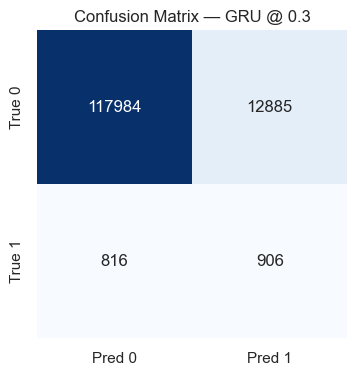

In [68]:
# Load threshold statistics (from notebook 06)
thresh_path = RESULTS_EVAL / "06_threshold_stats_test.csv"
thresh_df = pd.read_csv(thresh_path)

gru_row = thresh_df[
    (thresh_df["model_id"] == FINAL_MODEL_ID) &
    (thresh_df["threshold"] == FINAL_THRESHOLD)
].iloc[0]

display(gru_row)

print("\nKey final metrics for GRU @ 0.3")
print(f"Sensitivity (Recall): {gru_row['sensitivity']:.3f}")
print(f"Specificity        : {gru_row['specificity']:.3f}")
print(f"PPV (Precision)    : {gru_row['ppv']:.3f}")
print(f"NPV                : {gru_row['npv']:.3f}")
print(f"F1 score           : {gru_row['f1']:.3f}")

# Confusion matrix
cm = np.array([[gru_row["tn"], gru_row["fp"]],
               [gru_row["fn"], gru_row["tp"]]])

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", cbar=False,
            xticklabels=["Pred 0","Pred 1"],
            yticklabels=["True 0","True 1"], ax=ax)
ax.set_title(f"Confusion Matrix — GRU @ {FINAL_THRESHOLD}")
plt.show()


## Step 5 — Subgroup performance analysis

In [69]:
# Load GRU trajectories for TEST set
gru_test_traj = pd.read_csv(RESULTS_SEQ / "05_gru_risk_trajectories_test.csv")

# Merge demographics from labeled TEST set
test_label_df = pd.read_csv(RESULTS_LABELING / "02_labeling_eda_test.csv")

# Only pull demographics; Label_6h already exists in gru_test_traj
merged = gru_test_traj.merge(
    test_label_df[[PATIENT_COL, TIME_COL, "Gender", "Age"]],
    on=[PATIENT_COL, TIME_COL],
    how="left",
)

merged["pred"] = (merged["risk_gru_seq"] >= FINAL_THRESHOLD).astype(int)


def compute_group_metrics(df: pd.DataFrame, group_name: str) -> dict:
    y = df[LABEL_COL].values.astype(int)
    p = df["risk_gru_seq"].values
    yhat = df["pred"].values.astype(int)

    has_pos = (y == 1).any()
    has_neg = (y == 0).any()

    # AUROC: needs both positive and negative samples
    if has_pos and has_neg:
        try:
            auroc = metrics.roc_auc_score(y, p)
        except ValueError:
            auroc = np.nan
    else:
        auroc = np.nan

    # AUPRC: needs at least one positive sample
    auprc = metrics.average_precision_score(y, p) if has_pos else np.nan

    # Sensitivity (recall for positives)
    sens = metrics.recall_score(y, yhat, zero_division=0) if has_pos else np.nan

    # Specificity (recall for negatives)
    spec = metrics.recall_score(1 - y, 1 - yhat, zero_division=0) if has_neg else np.nan

    return {
        "group": group_name,
        "n": len(df),
        "auroc": auroc,
        "auprc": auprc,
        "sensitivity": sens,
        "specificity": spec,
    }


results = []

# Gender subgroups
for gender, df_sub in merged.groupby("Gender", observed=False):
    results.append(compute_group_metrics(df_sub, f"Gender={gender}"))

# Age bins
age_bins = pd.cut(merged["Age"], bins=[0, 40, 65, 120], labels=["<40", "40-65", ">65"])
for age_group, df_sub in merged.groupby(age_bins, observed=False):
    results.append(compute_group_metrics(df_sub, f"Age={age_group}"))

subgroup_df = pd.DataFrame(results)
display(subgroup_df)


,group,n,auroc,auprc,sensitivity,specificity
0,Gender=-1.1274418238207111,58872,0.820064,0.064359,0.533333,0.904092
1,Gender=0.8869637251979596,73719,0.807637,0.060934,0.521657,0.899500
2,Age=<40,76418,0.793101,0.053273,0.537020,0.885748
3,Age=40-65,0,NaN,NaN,NaN,NaN
4,Age=>65,0,NaN,NaN,NaN,NaN


## Step 6 — Case study: GRU trajectory for selected patient


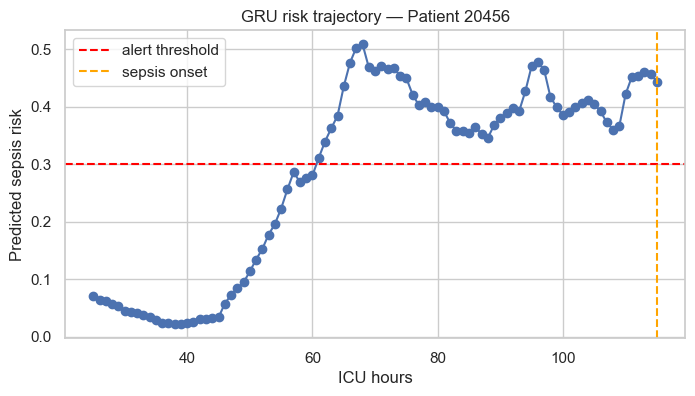

In [70]:
# Rebuild a TEST frame with GRU risk + sepsis onset time
gru_test_traj = pd.read_csv(RESULTS_SEQ / "05_gru_risk_trajectories_test.csv")
test_label_df = pd.read_csv(RESULTS_LABELING / "02_labeling_eda_test.csv", low_memory=False)

gru_test_with_onset = gru_test_traj.merge(
    test_label_df[[PATIENT_COL, TIME_COL, "sepsis_onset_time"]],
    on=[PATIENT_COL, TIME_COL],
    how="left",
    validate="one_to_one",
)

# Pick a septic patient (has defined sepsis onset)
septic_patients = (
    gru_test_with_onset[~gru_test_with_onset["sepsis_onset_time"].isna()][PATIENT_COL]
    .drop_duplicates()
)

assert len(septic_patients) > 0, "No septic patients with onset info found in TEST set."

patient_id = septic_patients.sample(1, random_state=RANDOM_SEED).iloc[0]
p = gru_test_with_onset[gru_test_with_onset[PATIENT_COL] == patient_id].sort_values(TIME_COL)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(p[TIME_COL], p["risk_gru_seq"], marker="o")
ax.axhline(FINAL_THRESHOLD, color="red", linestyle="--", label="alert threshold")

onset = p["sepsis_onset_time"].max()
if not np.isnan(onset):
    ax.axvline(onset, color="orange", linestyle="--", label="sepsis onset")

ax.set_title(f"GRU risk trajectory — Patient {patient_id}")
ax.set_ylabel("Predicted sepsis risk")
ax.set_xlabel("ICU hours")
ax.legend()
plt.show()


## Step 7 — GRU Input Saliency (explainability)


Loaded model metadata:
  features: 14
  mean/std stats loaded

GRU model restored and ready.
Sample sequence shape: torch.Size([1, 24, 14])

🔍 Top 20 most influential features:


Temp           0.002524
MAP            0.002002
Hour           0.001931
DBP            0.001238
O2Sat          0.000763
Age            0.000736
Unit2          0.000661
HR             0.000651
Gender         0.000629
HospAdmTime    0.000539
SBP            0.000508
Glucose        0.000490
Unit1          0.000416
Resp           0.000345
dtype: float32

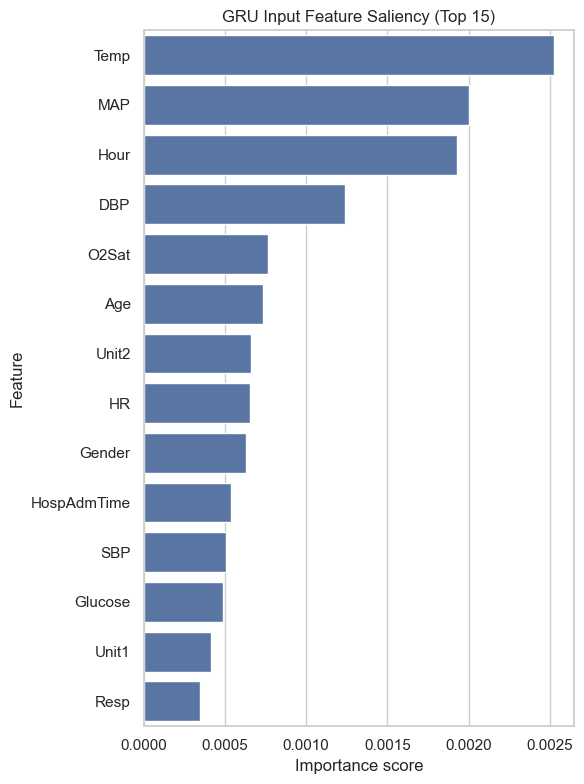

In [71]:

# === 7.1 Load GRU model, feature list, and normalization stats ===

model_path = RESULTS_SEQ / "gru_final_model.pt"
feat_path = RESULTS_SEQ / "gru_feature_cols.json"
norm_path = RESULTS_SEQ / "gru_norm_stats.json"

assert model_path.exists(), f"Missing: {model_path}"
assert feat_path.exists(), f"Missing: {feat_path}"
assert norm_path.exists(), f"Missing: {norm_path}"

with open(feat_path, "r") as f:
    seq_feature_cols = json.load(f)

with open(norm_path, "r") as f:
    norm_stats = json.load(f)

feat_mean = torch.tensor(norm_stats["mean"], dtype=torch.float32, device=DEVICE)
feat_std  = torch.tensor(norm_stats["std"], dtype=torch.float32, device=DEVICE)

print("Loaded model metadata:")
print("  features:", len(seq_feature_cols))
print("  mean/std stats loaded")


# === 7.2 Rebuild the GRU model architecture ===

class GRUSepsisModel(torch.nn.Module):
    def __init__(self, n_features, hidden_size=64, n_layers=1, dropout=0.1):
        super().__init__()
        self.gru = torch.nn.GRU(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, h_n = self.gru(x)
        logits = self.fc(h_n[-1]).squeeze(-1)
        return logits


model = GRUSepsisModel(n_features=len(seq_feature_cols)).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model.eval()

print("\nGRU model restored and ready.")


# === 7.3 Load a few TEST sequences for saliency computation ===

# Load TEST trajectories with raw features
test_df = pd.read_csv(RESULTS_LABELING / "02_labeling_eda_test.csv", low_memory=False)

# Filter features and normalize using saved stats
X = test_df[seq_feature_cols].values.astype(np.float32)
X = (X - feat_mean.cpu().numpy()) / feat_std.cpu().numpy()

# Convert ICU timeline into sequences of length 24
SEQ_LEN = 24
X_tensor = torch.tensor(X)
sequences = []
for i in range(SEQ_LEN, len(X_tensor)):
    sequences.append(X_tensor[i-SEQ_LEN:i])

sample_x = sequences[0].unsqueeze(0).to(DEVICE)    # (1, 24, num_features)
sample_x.requires_grad_(True)

print("Sample sequence shape:", sample_x.shape)


# === 7.4 Compute saliency ===

logits = model(sample_x)
loss = torch.nn.functional.binary_cross_entropy_with_logits(
    logits,
    torch.sigmoid(logits)  # self-label
)
loss.backward()

saliency = sample_x.grad.abs().mean(dim=0).mean(dim=0).detach().cpu().numpy()

imp = pd.Series(saliency, index=seq_feature_cols).sort_values(ascending=False)

print("\n🔍 Top 20 most influential features:")
display(imp.head(20))


# === Optional visualization ===
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(x=imp.head(15).values, y=imp.head(15).index, ax=ax)
ax.set_title("GRU Input Feature Saliency (Top 15)")
ax.set_xlabel("Importance score")
ax.set_ylabel("Feature")
plt.tight_layout()
plt.show()


## Step 8 — Online-style alert simulation for GRU on TEST set


In [72]:
# Load GRU risk trajectories for TEST
gru_test_traj = pd.read_csv(RESULTS_SEQ / "05_gru_risk_trajectories_test.csv")

# Load labeled TEST data (for sepsis onset time)
test_label_df = pd.read_csv(RESULTS_LABELING / "02_labeling_eda_test.csv", low_memory=False)

# Merge to get sepsis onset time and any extra covariates we want
gru_test_full = gru_test_traj.merge(
    test_label_df[[PATIENT_COL, TIME_COL, LABEL_COL, "sepsis_onset_time"]],
    on=[PATIENT_COL, TIME_COL, LABEL_COL],
    how="left",
    validate="one_to_one",
)

gru_test_full["risk"] = gru_test_full["risk_gru_seq"]
gru_test_full["alert_flag"] = (gru_test_full["risk"] >= FINAL_THRESHOLD).astype(int)

print("GRU TEST merged frame:", gru_test_full.shape)
display(gru_test_full.head())

GRU TEST merged frame: (132591, 9)


,Patient_ID,ICULOS,SepsisLabel,Label_6h,risk_gru_seq,split_05,sepsis_onset_time,risk,alert_flag
0,5,25,0,0,0.017628,test,NaN,0.017628,0
1,5,26,0,0,0.017293,test,NaN,0.017293,0
2,5,27,0,0,0.017103,test,NaN,0.017103,0
3,5,28,0,0,0.018947,test,NaN,0.018947,0
4,5,29,0,0,0.020009,test,NaN,0.020009,0


### Step 8.1 — First-alert time and time-gain distributions


In [73]:
rows = []

for pid, sub in gru_test_full.groupby(PATIENT_COL):
    sub_sorted = sub.sort_values(TIME_COL)
    onset_time = sub_sorted["sepsis_onset_time"].max()
    first_alert_rows = sub_sorted[sub_sorted["alert_flag"] == 1]

    first_alert_time = first_alert_rows[TIME_COL].iloc[0] if not first_alert_rows.empty else np.nan

    is_septic = not np.isnan(onset_time)
    if is_septic and not np.isnan(first_alert_time):
        time_gain = onset_time - first_alert_time
    else:
        time_gain = np.nan

    rows.append({
        PATIENT_COL: pid,
        "septic": int(is_septic),
        "onset_time": onset_time,
        "first_alert_time": first_alert_time,
        "time_gain_hours": time_gain,
    })

online_gain_df = pd.DataFrame(rows)
display(online_gain_df.head())

# Summary for septic patients only
septic = online_gain_df[online_gain_df["septic"] == 1].copy()
n_septic = len(septic)

median_gain = septic["time_gain_hours"].median()
q25, q75 = septic["time_gain_hours"].quantile([0.25, 0.75])

print(f"\n[GRU @ {FINAL_THRESHOLD}] Online-style time gain (septic patients only)")
print(f"n_septic: {n_septic}")
print(f"Median time gain (h): {median_gain:.2f}")
print(f"IQR time gain (h)   : [{q25:.2f}, {q75:.2f}]")

,Patient_ID,septic,onset_time,first_alert_time,time_gain_hours
0,5,0,NaN,NaN,NaN
1,8,0,NaN,NaN,NaN
2,14,0,NaN,NaN,NaN
3,24,0,NaN,NaN,NaN
4,35,0,NaN,NaN,NaN



[GRU @ 0.3] Online-style time gain (septic patients only)
n_septic: 305
Median time gain (h): 54.00
IQR time gain (h)   : [26.00, 106.00]


### Step 8.2 — Visualize alert timing for GRU (TEST)


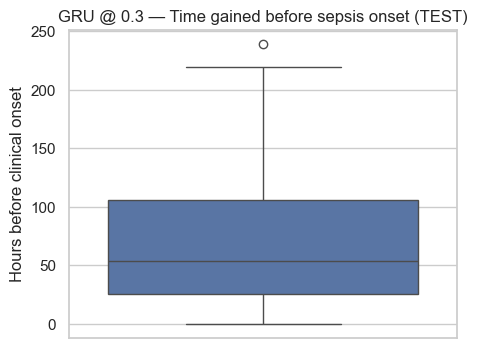

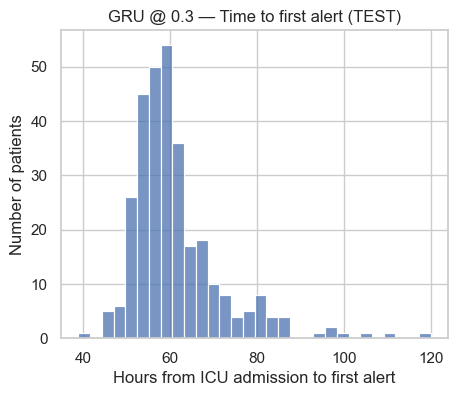

In [74]:
# Time gained before onset (septic only)
fig, ax = plt.subplots(figsize=(5, 4))
sns.boxplot(
    data=septic,
    y="time_gain_hours",
    ax=ax,
)
ax.set_title(f"GRU @ {FINAL_THRESHOLD} — Time gained before sepsis onset (TEST)")
ax.set_ylabel("Hours before clinical onset")
EXPORTED_FIGURES.append(("07_gru_time_gain_boxplot_test", fig))
plt.show()

# Time from ICU admission to first alert (all patients with an alert)
with_alert = online_gain_df[~online_gain_df["first_alert_time"].isna()].copy()

fig, ax = plt.subplots(figsize=(5, 4))
sns.histplot(
    with_alert["first_alert_time"],
    bins=30,
    kde=False,
    ax=ax,
)
ax.set_title(f"GRU @ {FINAL_THRESHOLD} — Time to first alert (TEST)")
ax.set_xlabel("Hours from ICU admission to first alert")
ax.set_ylabel("Number of patients")
EXPORTED_FIGURES.append(("07_gru_time_to_first_alert_hist_test", fig))
plt.show()

## Step 9 — Final project metric summary and export


In [75]:
# 1) Load per-family metric tables
baseline_metrics_path = RESULTS_BASELINES / "03_baseline_model_metrics.csv"
boosting_metrics_path = RESULTS_BOOSTING / "04_boosting_model_metrics.csv"
seq_metrics_path = RESULTS_SEQ / "05_sequence_model_metrics.csv"

baseline_metrics = pd.read_csv(baseline_metrics_path)
boosting_metrics = pd.read_csv(boosting_metrics_path)
seq_metrics = pd.read_csv(seq_metrics_path)

print("Baseline metrics:", baseline_metrics.shape)
print("Boosting metrics:", boosting_metrics.shape)
print("Sequence metrics:", seq_metrics.shape)

Baseline metrics: (6, 6)
Boosting metrics: (1, 5)
Sequence metrics: (2, 11)


### Step 9.1 — Merge family-level metrics into a single table


In [76]:
# Keep only TEST rows where present
baseline_test = baseline_metrics[baseline_metrics["split"] == "TEST"].copy()
baseline_test["family"] = "baseline"

boosting_test = boosting_metrics.copy()
boosting_test["family"] = "boosting"

seq_test = seq_metrics.copy()
seq_test["family"] = "sequence"

family_summary = pd.concat([baseline_test, boosting_test, seq_test], ignore_index=True)

# Optional: sort models nicely
family_summary = family_summary.sort_values(["family", "model"]).reset_index(drop=True)

display(family_summary)

family_summary_path = RESULTS_THIS / "07_family_level_metrics_summary.csv"
family_summary.to_csv(family_summary_path, index=False)
print("Saved family-level metrics summary to:", family_summary_path)

,model,split,auroc,auprc,f1,acc,family,test_auroc,test_auprc,test_f1,test_acc,val_loss,val_auroc,val_auprc,val_f1,val_acc,test_loss
0,logreg,TEST,0.763779,0.042405,0.049068,0.783763,baseline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,random_forest,TEST,0.792511,0.044287,0.000000,0.991185,baseline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,xgboost,TEST,0.804823,0.045339,0.066870,0.854986,baseline,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xgboost_timewindow,NaN,NaN,NaN,NaN,NaN,boosting,0.823837,0.055156,0.077582,0.858296,NaN,NaN,NaN,NaN,NaN,NaN
4,gru_sequence,NaN,NaN,NaN,NaN,NaN,sequence,0.814126,0.061930,0.061109,0.981228,0.297694,0.795711,0.072246,0.080353,0.981969,0.284629
5,lstm_sequence,NaN,NaN,NaN,NaN,NaN,sequence,0.803488,0.058403,0.090572,0.966679,0.306552,0.785552,0.074455,0.158299,0.972622,0.291344


Saved family-level metrics summary to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\07_final_analysis\07_family_level_metrics_summary.csv


### Step 9.2 — Final test operating-point summary (thr = 0.3)


In [77]:
threshold_stats_df = pd.read_csv(RESULTS_EVAL / "06_threshold_stats_test.csv")
global_metrics_df = pd.read_csv(RESULTS_EVAL / "06_global_metrics_test.csv")

thr_03 = threshold_stats_df[threshold_stats_df["threshold"] == 0.3].copy()
thr_03 = thr_03.merge(
    global_metrics_df[["model_id", "auroc", "auprc", "brier"]],
    on="model_id",
    how="left",
    suffixes=("", "_global"),
)

# Time gain summary per model (recompute quickly from per-patient file)
tg_all = pd.read_csv(RESULTS_EVAL / "06_time_gain_per_patient_test.csv")
tg_septic = tg_all[tg_all["septic"] == 1].copy()

tg_summary = (
    tg_septic
    .groupby("model_id")["time_gain_hours"]
    .agg(
        median_time_gain_hours="median",
        q25_time_gain_hours=lambda s: s.quantile(0.25),
        q75_time_gain_hours=lambda s: s.quantile(0.75),
    )
    .reset_index()
)

final_operating = thr_03.merge(tg_summary, on="model_id", how="left")

final_operating["is_selected_final_model"] = final_operating["model_id"] == FINAL_MODEL_ID

cols_order = [
    "model_id", "model_name", "threshold", "split",
    "auroc", "auprc", "brier",
    "sensitivity", "specificity", "ppv", "npv", "f1",
    "alerts_per_100_patient_days",
    "median_time_gain_hours", "q25_time_gain_hours", "q75_time_gain_hours",
    "is_selected_final_model",
]

final_operating = final_operating[cols_order].sort_values("auprc", ascending=False)
display(final_operating)

final_operating_path = RESULTS_THIS / "07_final_operating_point_summary_test.csv"
final_operating.to_csv(final_operating_path, index=False)
print("Saved final operating-point summary to:", final_operating_path)

,model_id,model_name,threshold,split,auroc,auprc,brier,sensitivity,specificity,ppv,npv,f1,alerts_per_100_patient_days,median_time_gain_hours,q25_time_gain_hours,q75_time_gain_hours,is_selected_final_model
4,gru_seq,GRU sequence model (24h history),0.3,test,0.814126,0.061930,0.028140,0.526132,0.901543,0.065695,0.993131,0.116805,249.627803,54.0,26.0,106.00,True
5,lstm_seq,LSTM sequence model (24h history),0.3,test,0.803488,0.058403,0.032793,0.552265,0.889905,0.061918,0.993423,0.111352,278.009820,52.0,18.0,109.00,False
3,xgb_timewindow,XGBoost + multi-window features (3/6/12h),0.3,test,0.823837,0.055156,0.125483,0.804245,0.661172,0.022677,0.997114,0.044110,824.000986,42.0,13.0,97.75,False
2,xgb_baseline,XGBoost baseline (6h window features),0.3,test,0.804823,0.045339,0.130023,0.807414,0.624334,0.018748,0.997265,0.036646,910.727922,42.0,14.0,99.75,False
1,rf_baseline,Random forest (6h window features),0.3,test,0.792511,0.044287,0.009477,0.025991,0.997538,0.085795,0.991395,0.039895,6.406343,49.0,15.5,82.00,False
0,logreg_baseline,Logistic regression (6h window features),0.3,test,0.763779,0.042405,0.186536,0.911376,0.290568,0.011291,0.997296,0.022306,1706.907543,41.0,15.0,98.00,False


Saved final operating-point summary to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\07_final_analysis\07_final_operating_point_summary_test.csv


### Step 9.3 — Export all Notebook 07 figures


In [78]:
for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    print("Saved figure:", out_path)

print("\nAll Notebook 07 figures successfully exported.")


Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\07_final_analysis\07_gru_time_gain_boxplot_test.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\07_final_analysis\07_gru_time_to_first_alert_hist_test.png

All Notebook 07 figures successfully exported.
